# Read files

In [1]:
import awkward as ak
import numpy as np
import os

In [2]:
basedir = {
    year: {
        r'Top+$\gamma$': [f'../condor/output/mc/{year}/{channel}/' for channel in ['TTGJets']],
        r'Z+$\gamma$': [f'../condor/output/mc/{year}/{channel}/' for channel in ['ZGToLLG', 'ZGToJJG']],
        r'W+$\gamma$': [f'../condor/output/mc/{year}/{channel}/' for channel in ['WGToLNuG', 'WGToJJG']],
        r'fake $\gamma$ events': [f'../condor/output/mc/{year}/{channel}/' for channel in ['ST', 'TTJets', 'ZJetsToNuNu', 'ZJetsToLL', 'ZJetsToQQ', 'WJetsToLNu', 'WJetsToQQ', 'QCD']],
        r'QCD+$\gamma$': [f'../condor/output/mc/{year}/{channel}/' for channel in ['GJets']],
        r'$Z^\mathrm{\prime}(1TeV)\to H\gamma$': [f'../condor/output/mc/{year}/ZpToHG/ZpToHGamma_M1000/'],
        r'$Z^\mathrm{\prime}(2TeV)\to H\gamma$': [f'../condor/output/mc/{year}/ZpToHG/ZpToHGamma_M2000/'],
        r'$Z^\mathrm{\prime}(3TeV)\to H\gamma$': [f'../condor/output/mc/{year}/ZpToHG/ZpToHGamma_M3000/'],
        'data': [f'../condor/output/data/{year}/' + ('SinglePhoton' if year!='2018' else 'EGamma')],
    } for year in ['2016pre', '2016post', '2017', '2018']
}

BKG = set([k for k in basedir['2018'].keys() if not (r'H\gamma' in k or k=='data')])
SIG_COLOR = {
    r'$Z^\mathrm{\prime}(1TeV)\to H(bb)\gamma$': 'red',
    r'$Z^\mathrm{\prime}(2TeV)\to H(bb)\gamma$': 'blue',
    r'$Z^\mathrm{\prime}(3TeV)\to H(bb)\gamma$': 'gold',
}

filepath={year: {c: [] for c in basedir[year]} for year in basedir}
for year, paths in basedir.items():
    for mc, folders in paths.items():
        for folder in folders:
            for (current_path, dirs, files) in os.walk(folder):
                for f in files:
                    if f.endswith('.parq'):
                        filepath[year][mc].append(os.path.join(current_path, f))

In [3]:
events = {year: {k: [] for k in filepath[year]} for year in filepath}
for year in filepath:
    for k, v in filepath[year].items():
        for f in v:
            if os.path.getsize(f) == 0 or len(ak.from_parquet(f))==0:
                continue
            array = ak.from_parquet(f)
            if len(array)>0:
                events[year][k].append(array)
        if len(events[year][k]) > 0:
            events[year][k] = ak.concatenate(events[year][k], axis=0)

weight={y: {c: events[y][c].event_final_weight for c in events[y] if c!='data' and len(events[y][c])>0} for y in events}
del events['2016pre'][r'$Z^\mathrm{\prime}(2TeV)\to H\gamma$']
del events['2016post'][r'$Z^\mathrm{\prime}(2TeV)\to H\gamma$']

# Decomposite signal

In [ ]:
def decomposite(signal: ak.Array):
    HWW_decay_mode = ak.fill_none(signal['gen_HWW_decay_mode'], 0)
    
    signal['HWW_4q'] = signal['gen_ZpToH(WW)Gamma'] & (HWW_decay_mode >= 32)
    
    signal['HWW_qqlv'] = signal['gen_ZpToH(WW)Gamma'] & (HWW_decay_mode > 16) & (HWW_decay_mode < 32)
    
    signal['HWW_lvlv'] = signal['gen_ZpToH(WW)Gamma'] & (HWW_decay_mode <= 16)
    
    return signal

DECOMPOSITE = True
if DECOMPOSITE:
    y='2018'
    for c in list(events[y].keys()):
        if r'H\gamma' in c:
            events[y].update({c: decomposite(events[y][c])})
            events[y][c.replace(r'H\gamma', r'H(WW)\gamma')] = events[y][c][events[y][c]['gen_ZpToH(WW)Gamma']]
            events[y][c.replace(r'H\gamma', r'H(bb)\gamma')] = events[y][c][events[y][c]['gen_ZpToH(bb)Gamma']]
            weight[y][c.replace(r'H\gamma', r'H(WW)\gamma')] = weight[y][c][events[y][c]['gen_ZpToH(WW)Gamma']]
            weight[y][c.replace(r'H\gamma', r'H(bb)\gamma')] = weight[y][c][events[y][c]['gen_ZpToH(bb)Gamma']]

events

{'2016pre': {'Top+fake $\\gamma$': [],
  'Top+$\\gamma$': [],
  'Z+fake $\\gamma$': [],
  'Z+$\\gamma$': [],
  'W+fake $\\gamma$': [],
  'W+$\\gamma$': [],
  'QCD+fake $\\gamma$': [],
  'QCD+$\\gamma$': [],
  'data': []},
 '2016post': {'Top+fake $\\gamma$': [],
  'Top+$\\gamma$': [],
  'Z+fake $\\gamma$': [],
  'Z+$\\gamma$': [],
  'W+fake $\\gamma$': [],
  'W+$\\gamma$': [],
  'QCD+fake $\\gamma$': [],
  'QCD+$\\gamma$': [],
  'data': []},
 '2017': {'Top+fake $\\gamma$': [],
  'Top+$\\gamma$': [],
  'Z+fake $\\gamma$': [],
  'Z+$\\gamma$': [],
  'W+fake $\\gamma$': [],
  'W+$\\gamma$': [],
  'QCD+fake $\\gamma$': [],
  'QCD+$\\gamma$': [],
  '$Z^\\mathrm{\\prime}(2TeV)\\to H\\gamma$': [],
  'data': []},
 '2018': {'Top+$\\gamma$': <Array [{...}, {...}, {...}, ..., {...}, {...}] type='12692 * {AK8jet_rankT...'>,
  'Z+$\\gamma$': <Array [{...}, {...}, {...}, ..., {...}, {...}] type='45337 * {AK8jet_rankT...'>,
  'W+$\\gamma$': <Array [{...}, {...}, {...}, ..., {...}, {...}] type='83798 *

# Define tagger

In [ ]:
score_all = [
    'AK8jet_inclParTMDV1_probHWqqWev0c',
    'AK8jet_inclParTMDV1_probHWqqWev1c',
    'AK8jet_inclParTMDV1_probHWqqWmv0c',
    'AK8jet_inclParTMDV1_probHWqqWmv1c',
    'AK8jet_inclParTMDV1_probHWqqWq0c',
    'AK8jet_inclParTMDV1_probHWqqWq1c',
    'AK8jet_inclParTMDV1_probHWqqWq2c',
    'AK8jet_inclParTMDV1_probHWqqWqq0c',
    'AK8jet_inclParTMDV1_probHWqqWqq1c',
    'AK8jet_inclParTMDV1_probHWqqWqq2c',
    'AK8jet_inclParTMDV1_probHWqqWtauev0c',
    'AK8jet_inclParTMDV1_probHWqqWtauev1c',
    'AK8jet_inclParTMDV1_probHWqqWtauhv0c',
    'AK8jet_inclParTMDV1_probHWqqWtauhv1c',
    'AK8jet_inclParTMDV1_probHWqqWtaumv0c',
    'AK8jet_inclParTMDV1_probHWqqWtaumv1c',
    'AK8jet_inclParTMDV1_probHbb',
    'AK8jet_inclParTMDV1_probHcc',
    'AK8jet_inclParTMDV1_probHqq',
    'AK8jet_inclParTMDV1_probHss',
    'AK8jet_inclParTMDV1_probHtauhtaue',
    'AK8jet_inclParTMDV1_probHtauhtauh',
    'AK8jet_inclParTMDV1_probHtauhtaum',
    'AK8jet_inclParTMDV1_probQCDb',
    'AK8jet_inclParTMDV1_probQCDbb',
    'AK8jet_inclParTMDV1_probQCDc',
    'AK8jet_inclParTMDV1_probQCDcc',
    'AK8jet_inclParTMDV1_probQCDothers',
    'AK8jet_inclParTMDV1_probTopbWev',
    'AK8jet_inclParTMDV1_probTopbWmv',
    'AK8jet_inclParTMDV1_probTopbWq0c',
    'AK8jet_inclParTMDV1_probTopbWq1c',
    'AK8jet_inclParTMDV1_probTopbWqq0c',
    'AK8jet_inclParTMDV1_probTopbWqq1c',
    'AK8jet_inclParTMDV1_probTopbWtauev',
    'AK8jet_inclParTMDV1_probTopbWtauhv',
    'AK8jet_inclParTMDV1_probTopbWtaumv',
]

score_Higgs = [k for k in score_all if k.startswith('AK8jet_inclParTMDV1_probH')]

score_HWW = [
    'AK8jet_inclParTMDV1_probHWqqWev0c',
    'AK8jet_inclParTMDV1_probHWqqWev1c',
    'AK8jet_inclParTMDV1_probHWqqWmv0c',
    'AK8jet_inclParTMDV1_probHWqqWmv1c',
    'AK8jet_inclParTMDV1_probHWqqWq0c',
    'AK8jet_inclParTMDV1_probHWqqWq1c',
    'AK8jet_inclParTMDV1_probHWqqWq2c',
    'AK8jet_inclParTMDV1_probHWqqWqq0c',
    'AK8jet_inclParTMDV1_probHWqqWqq1c',
    'AK8jet_inclParTMDV1_probHWqqWqq2c',
    'AK8jet_inclParTMDV1_probHWqqWtauev0c',
    'AK8jet_inclParTMDV1_probHWqqWtauev1c',
    'AK8jet_inclParTMDV1_probHWqqWtauhv0c',
    'AK8jet_inclParTMDV1_probHWqqWtauhv1c',
    'AK8jet_inclParTMDV1_probHWqqWtaumv0c',
    'AK8jet_inclParTMDV1_probHWqqWtaumv1c',
]

score_QCD = [
    'AK8jet_inclParTMDV1_probQCDb',
    'AK8jet_inclParTMDV1_probQCDbb',
    'AK8jet_inclParTMDV1_probQCDc',
    'AK8jet_inclParTMDV1_probQCDcc',
    'AK8jet_inclParTMDV1_probQCDothers',
]

In [ ]:
y = '2018'
Hbb_tagger = {
    k: (getattr(events[y][k], 'AK8jet_inclParTMDV1_probHbb') / 
        ak.sum([getattr(events[y][k], d) for d in ['AK8jet_inclParTMDV1_probHbb']+score_QCD], axis=0)
    ) for k in events[y]
}

# Prepare plotting

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return np.abs(h), var

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11)
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    return np.array([down_error_bar, up_error_bar])

# Fitting

In [ ]:
import scipy as sp
import scipy.stats as sps
from scipy.optimize import curve_fit
from scipy.stats import crystalball

## playground

In [ ]:
# Internuclear separation in angstroms
distances = [2.875, 3.0, 3.125, 3.25, 3.375, 3.5, 3.75, 4.0, 4.5, 5.0, 6.0]
# Energy in Wavenumbers
energies = [0.35334378061169025, -2.7260131253801405, -4.102738968283382, -4.557042640311599, -4.537519193684069, -4.296388508321034, -3.6304745046204117, -3.0205368595885536, -2.1929538006724814, -1.7245616790238782, -1.2500789753171557]

distances, energies = np.array(distances), np.array(energies)

In [ ]:
def Lennard_Jones(x, epsilon, sigma):
    y = 4*epsilon*((sigma/x)**12 - (sigma/x)**6)
    return y

[4.85719609 2.8927437 ]


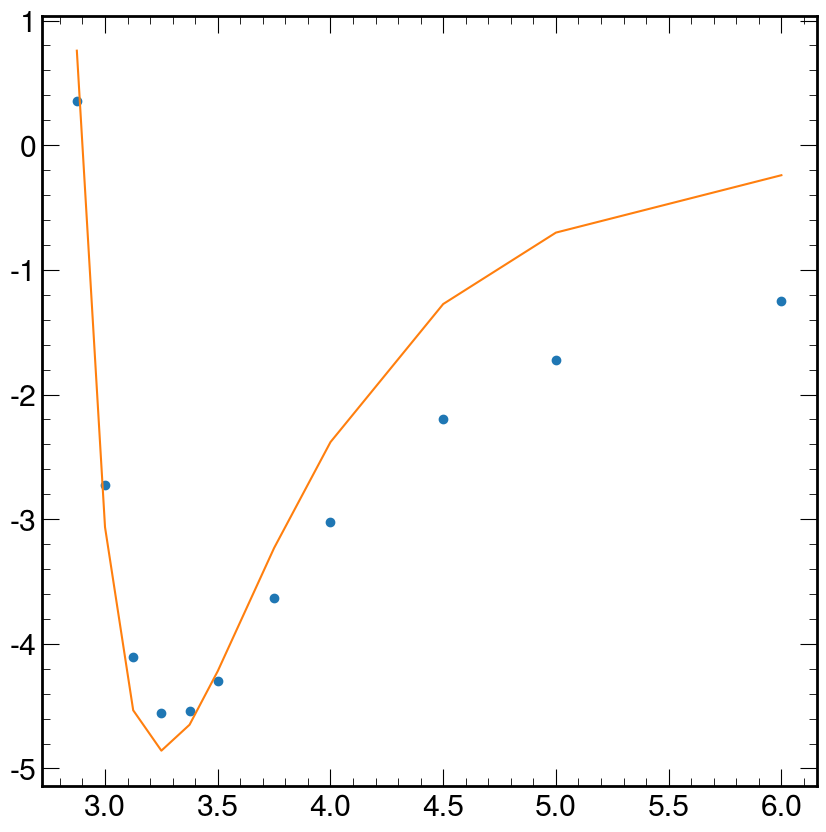

In [ ]:
parameters, covariance = curve_fit(Lennard_Jones, xdata=distances, ydata=energies, bounds=([4, 3/2], [+np.inf, +np.inf]))
fit_result = Lennard_Jones(distances, *parameters)

plt.plot(distances, energies, 'o', label='data')
plt.plot(distances, fit_result, '-', label='fit')
print(parameters)

## work

### signal

In [ ]:
def crystallBall(x, beta, m, xbar, sigma, N):
    pdf = sp.stats.crystalball.pdf(x, beta=beta, m=m, loc=xbar, scale=sigma)
    return N * pdf

In [ ]:
hep.style.use("CMS")

def signal_fitplot(arrays, weight, plot_name: str, x_name: str, cuts=None, year='2018', bins: int=40, x_min: float=0, x_max: float=2000, overflow=True, underflow=False):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
        
    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(1, 1)
    ax = f.add_subplot(gs[0])
    plt.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    
    ## analyze
    individual = {'h': {}, 'var': {}}
    
    for (k,v) in arrays.items():
        mass_center = float(k.split('(')[1][0]) * 1e3
        mass_std = ak.std(arrays[k], weight=weight[k])
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        x_data = bh.axis.Regular(bins, x_min, x_max).centers
        if 'delta_phi' in plot_name:
            values = np.min([v, 2*np.pi-v], axis=0)
        values = ak.fill_none(v, -999)
        
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        
        if k not in BKG:
            individual['h'][k] = h
            individual['var'][k] = var
        
    ## plot
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    for (k, h) in individual['h'].items():
        if k in SIG_COLOR:  # signal
            err = error_bar(h, individual['var'][k], type='mc')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, histtype='errorbar', stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
            parameters, covariance = curve_fit(crystallBall, xdata=x_data, ydata=h, p0=[1, 2, mass_center, 50, 5])
            x_fit = bh.axis.Regular(4*bins, x_min, x_max).centers
            fit_result = crystallBall(x_fit, *parameters)
            plt.plot(x_fit, fit_result, label='fit', linestyle='dashed')


    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    ax.set_ylim(0, ax.get_ylim()[1]*1.2)
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    ax.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax.set_ylabel('Events', fontsize=20, ha='right', y=1)


    plt.xticks(size=16)
    plt.yticks(size=16)

    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')

    ## finalizing
    if not os.path.exists('./plots/fit'):
        os.makedirs('./plots/fit')
    plt.savefig(f"./plots/fit/{year}_{plot_name}.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
SR_cut="""((events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
(np.abs(events[y][k].photon_eta) < 1.4442) &
(np.abs(events[y][k].AK8jet_eta) < 2.4) &
(events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35))"""#(Hbb_tagger[k] > 0.9))


/tmp/ipykernel_655684/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_655684/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_655684/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/home/dfu/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:9623: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/home/dfu/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:9623: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


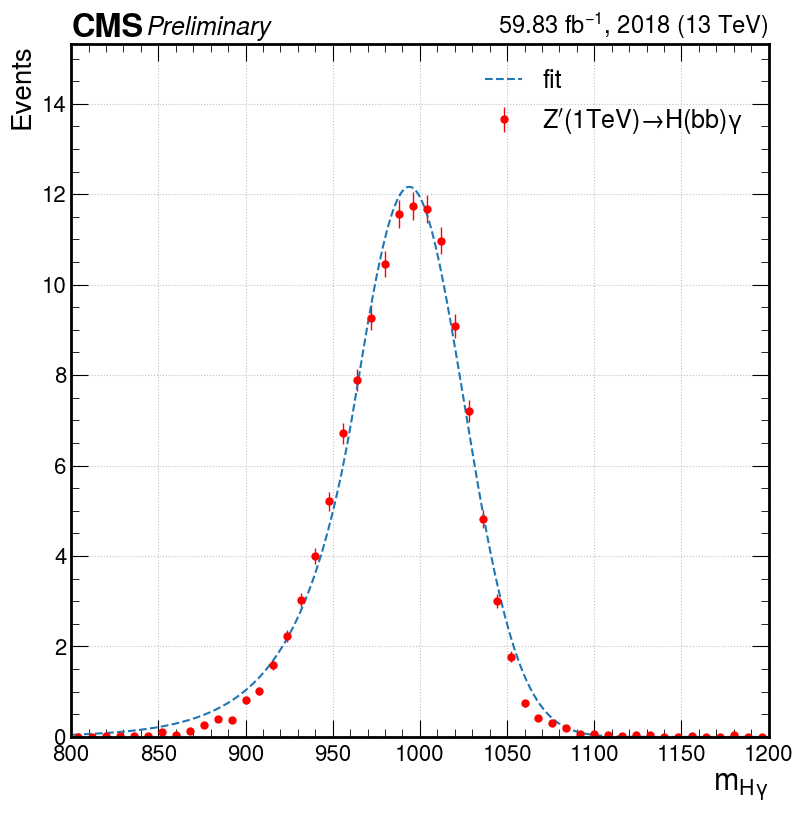

/home/dfu/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:9623: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/home/dfu/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:9623: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


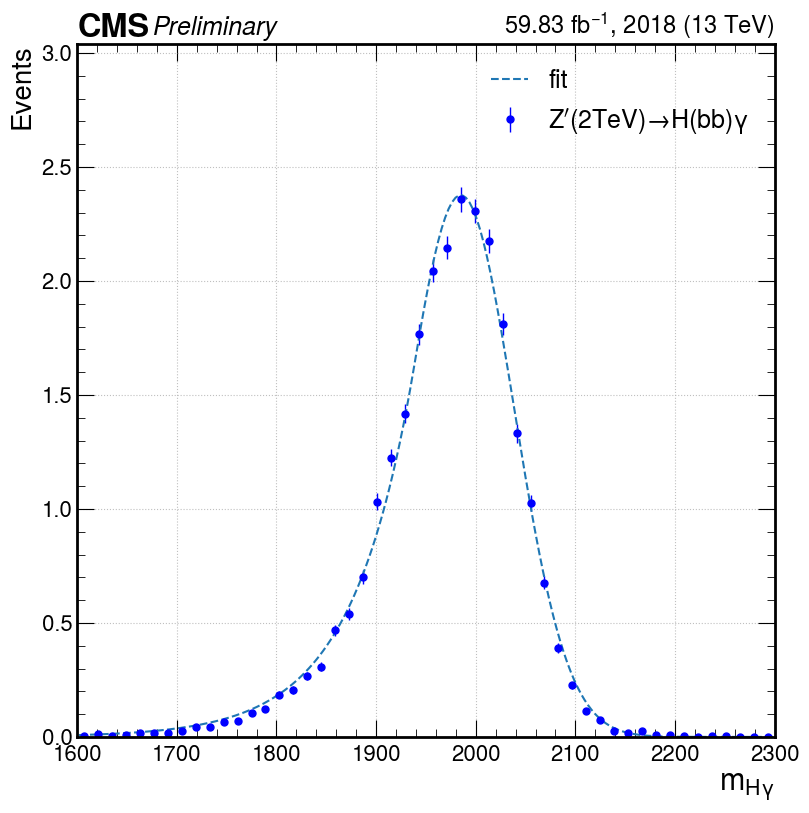

/tmp/ipykernel_655684/3056255085.py:31: RuntimeWarning: invalid value encountered in divide
  number = h**2 / var
/tmp/ipykernel_655684/3056255085.py:47: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= var/h
/tmp/ipykernel_655684/3056255085.py:48: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= var/h
/home/dfu/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:9623: RuntimeWarning: overflow encountered in power
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *
/home/dfu/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:9623: RuntimeWarning: invalid value encountered in multiply
  return ((m/beta)**m * np.exp(-beta**2 / 2.0) *


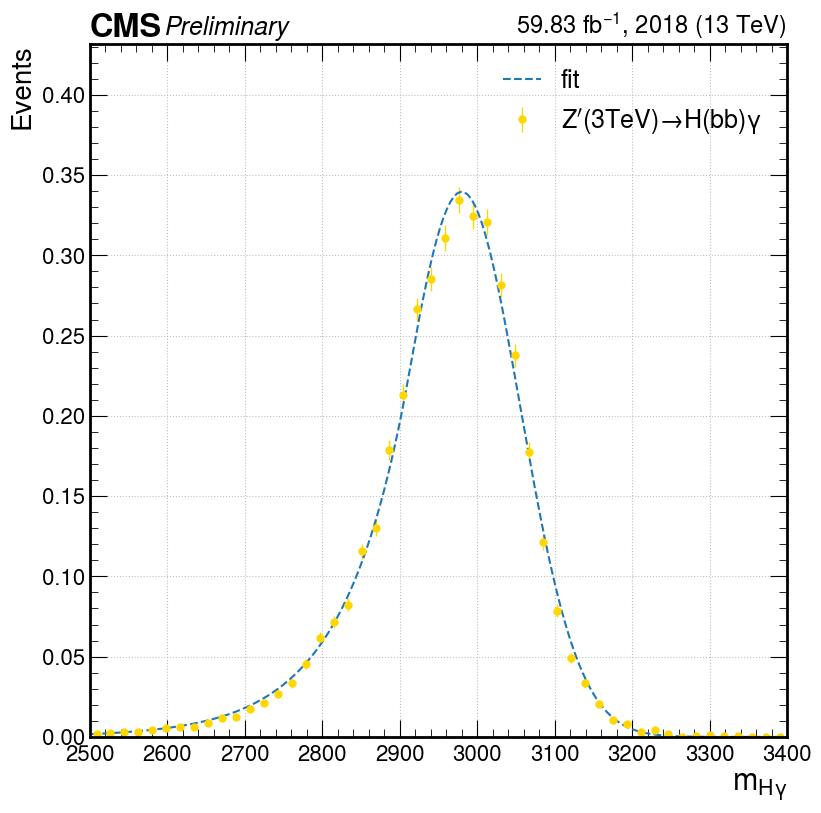

In [ ]:
y = '2018'

arrays={k: events[y][k]['photon+jet_mass'] for k in events[y] if k in SIG_COLOR and '1' in k}
arrays = {k: v[eval(SR_cut)] for k, v in arrays.items()}
_weight = {k: weight[y][k][eval(SR_cut)] for k in weight[y]}
signal_fitplot(arrays=arrays, weight=_weight, x_name=r'$m_{H\gamma}$', plot_name='m_Zp=1TeV', bins=50, x_min=800, x_max=1200, overflow=False, underflow=False, year='2018')

arrays={k: events[y][k]['photon+jet_mass'] for k in events[y] if k in SIG_COLOR and '2' in k}
arrays = {k: v[eval(SR_cut)] for k, v in arrays.items()}
_weight = {k: weight[y][k][eval(SR_cut)] for k in weight[y]}
signal_fitplot(arrays=arrays, weight=_weight, x_name=r'$m_{H\gamma}$', plot_name='m_Zp=2TeV', bins=50, x_min=1600, x_max=2300, overflow=False, underflow=False, year='2018')

arrays={k: events[y][k]['photon+jet_mass'] for k in events[y] if k in SIG_COLOR and '3' in k}
arrays = {k: v[eval(SR_cut)] for k, v in arrays.items()}
_weight = {k: weight[y][k][eval(SR_cut)] for k in weight[y]}
signal_fitplot(arrays=arrays, weight=_weight, x_name=r'$m_{H\gamma}$', plot_name='m_Zp=3TeV', bins=50, x_min=2500, x_max=3400, overflow=False, underflow=False, year='2018')

### background

In [ ]:
CR_cut="""((
    ((events[y][k]['AK8jet_msoftdrop'] > 100) & (events[y][k]['AK8jet_msoftdrop'] < 140)) | 
    ((events[y][k]['AK8jet_msoftdrop'] > 140) & (events[y][k]['AK8jet_msoftdrop'] < 170))
) & 
(np.abs(events[y][k].photon_eta) < 1.4442) &
(np.abs(events[y][k].AK8jet_eta) < 2.4) & 
(events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35))"""#(Hbb_tagger[k] > 0.9))

In [ ]:
def log_dijet(x, log_p0, p1, p2):
    log_x = np.log(x)
    log_y = log_p0 + (p1+p2*log_x)*log_x
    return log_y

def background_fitplot(arrays, weight, plot_name: str, x_name: str, cuts=None, year='2018', bins: int=40, x_min: float=0, x_max: float=2000, overflow=True, underflow=False, intial_parameters=None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
        
    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    ax1 = f.add_subplot(gs[1])
    ax.grid()
    ax1.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    
    ## analyze
    individual = {'h': {}, 'var': {}}
    
    x_axis = bh.axis.Regular(bins, x_min, x_max)
    hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
    x_data = x_axis.centers
    
    for (k,v) in arrays.items():
        values = ak.fill_none(v, -999)
        
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        
        if k not in BKG:
            individual['h'][k] = h
            individual['var'][k] = var

        
    ## plot
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    for (k, h) in individual['h'].items():
        err = error_bar(h, individual['var'][k], type='mc')
        hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, histtype='errorbar', stack=False, linewidth=2, ax=ax, color='black')
        parameters, covariance = curve_fit(log_dijet, xdata=x_data[h>0], ydata=np.log(h[h>0]), p0=intial_parameters)
        fit_result = np.exp(log_dijet(x_data, *parameters))
        ax.plot(x_data, fit_result, label='fit', linestyle='dashed')
        hep.histplot((fit_result-h)/err, bins=hist.axes[0].edges, label=k, histtype='fill', stack=False, ax=ax1, color='red')



    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_yscale('log')
    ax.set_xticklabels([])
    ax.set_ylim(1e-1, ax.get_ylim()[1]*1e1)
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    # ax.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    
    # ratio panel
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(1.2*ax1.get_ylim()[0], 1.2*ax1.get_ylim()[1])
    # ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.set_ylabel(r'$\frac{fit - data}{data\ unc.}$', fontsize=20, ha='center', y=0.5)

    plt.xticks(size=16)
    plt.yticks(size=16)

    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')

    ## finalizing
    if not os.path.exists('./plots/fit'):
        os.makedirs('./plots/fit')
    plt.savefig(f"./plots/fit/{year}_{plot_name}.pdf", bbox_inches='tight')
    plt.show()

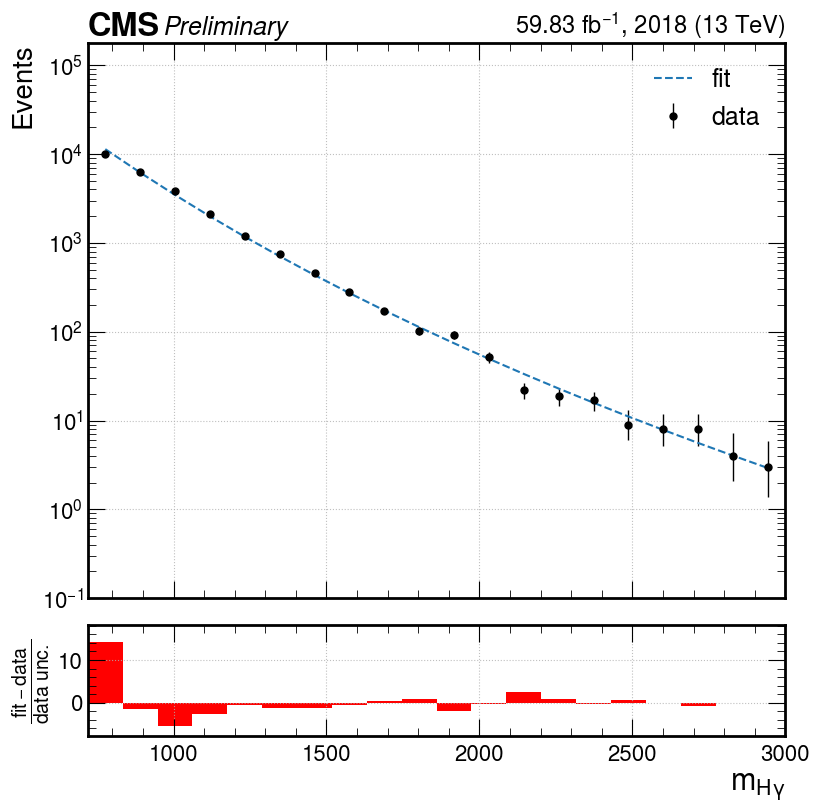

In [ ]:
y = '2018'

arrays={k: events[y][k]['photon+jet_mass'] for k in events[y] if k == 'data'}
arrays = {k: v[eval(CR_cut)] for k, v in arrays.items()}
background_fitplot(arrays=arrays, weight=None, x_name=r'$m_{H\gamma}$', plot_name='background_in_CR', bins=30, x_min=720, x_max=3500, overflow=False, underflow=False, year=y, intial_parameters=[np.log(3e3), 400, -2])

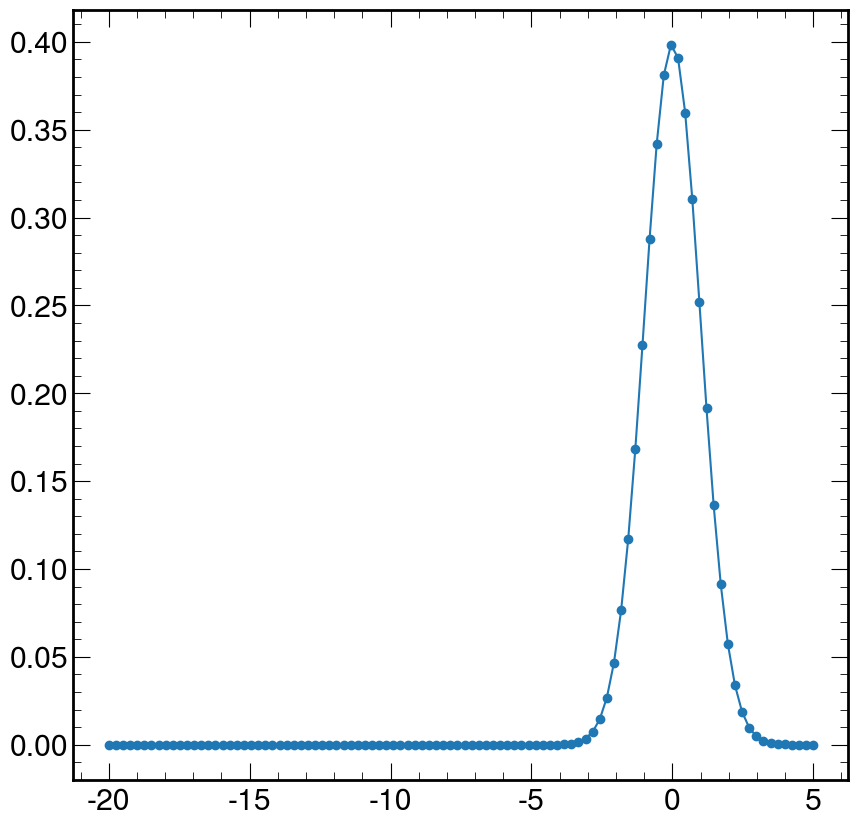

In [58]:
x = np.linspace(start=-20, stop=5, num=100)
parameters = {'beta': 10, 'xbar': 0, 'sigma': 1, 'N': 1, 'm': 5}

fit_result = np.array([crystallBall(x=i, **parameters) for i in x])

plt.plot(x, fit_result, '-o', label='fit')

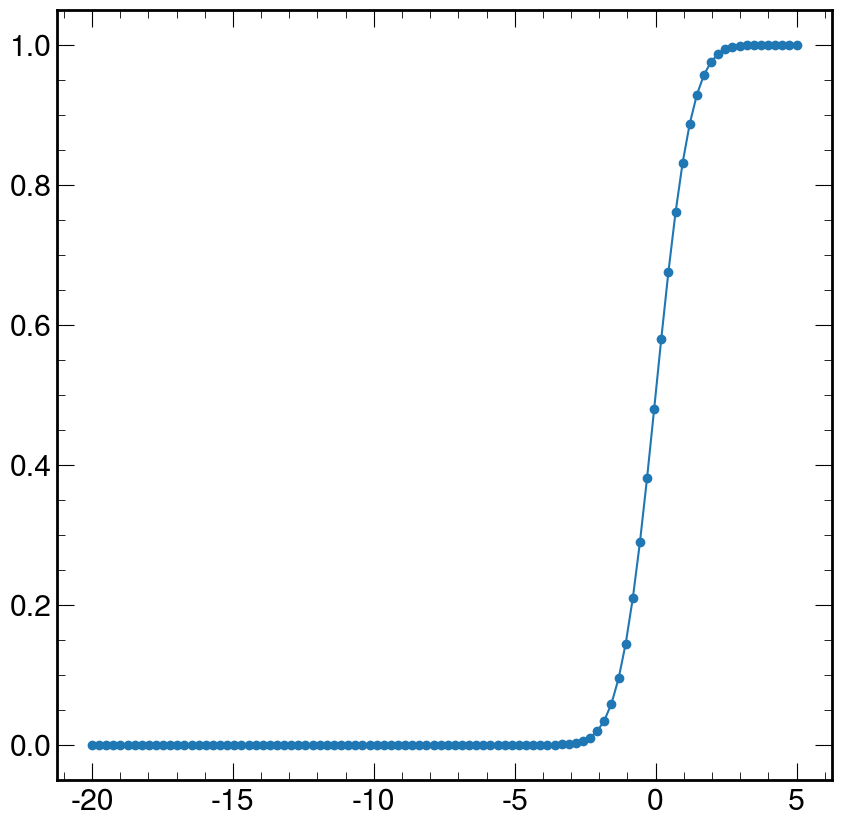

In [46]:
cdf = sps.crystalball.cdf(x=x, beta=10, m=5, loc=0, scale=1)
plt.plot(x, cdf, '-o', label='fit')

In [49]:
sps.kstest(stats.uniform.rvs(size=100, random_state=rng), cdf)

KstestResult(statistic=0.72, pvalue=2.6766397956445386e-25, statistic_location=0.03451817399720775, statistic_sign=-1)